# Making Output for the Multiresolution Network

The network definition is stored in the module **MultiResSmallNetwork** in the directory src/models/

In this Notebook, we want to generate the output for a part of an WSI at 5x. We start by specifying some global variables. 

## Specifying the configuration

In [1]:
# The path to the image from which we want to make the output. 
fpath = r'/home/ltran/data/test/slide1.png'
# The path to the model and the associated network
modelpath = r"/home/ltran/trg_ltran/models/multi/multires-8classes-v0.pth" 
n_classes =8

class_names=["Fat", "Muscular", "Vessle", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"]
#class_names = ["Fat", "Muscular", "Vessle", "Gland", "Stroma", "Tumor", "Epithelium"]
modulepath = '/home/ltran/trg_ltran/'
nclasses=len(class_names)

# resize, padsize, patch_size and batch_size used for the model 
resize_resolutions=[1,.25] #resize input image, base and second
patch_size=64
patch_size_res2 = 128
mirror_pad_size = patch_size_res2
batch_size=128 #should be a power of 2

# number of initialized SLIC segments. 
n_segments = 200000//(64*64//600)

## Import the necessary modules

In [2]:
import sys
sys.path.insert(0,modulepath)

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal
import argparse
from torch import nn
from torchsummary import summary

from skimage import color 

from albumentations import *
from albumentations.pytorch import ToTensor

import sklearn.feature_extraction.image

import matplotlib.cm

import torch

#We also import the modules in /src/
from src.models.MultiResSmallNetwork import MergeSmallNetworks
from src.output.helpers import Preprocess, CentersSLIC, Intersection, MakeOutput, OutputMasks

from tqdm.autonotebook import tqdm

from  skimage.color import rgb2gray
import PIL

import glob

import dill as pickle

from skimage.color import rgb2gray, rgb2hed

from skimage.measure import * 
from skimage.filters import *
from skimage.morphology import *
import time

/home/ltran/trg_ltran/src/output/helpers.py:44: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [31]:
def Preprocess(img, resize, mirror_pad_size, patch_size_res2):
    img= cv2.resize(img,(0,0),fx=resize,fy=resize, interpolation=PIL.Image.BICUBIC) #resize it as specified above
    img = np.pad(img, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
    #create the coresponding mask by using hematoxylin
    #hed=rgb2hed(img)
    mask=img[:, :, 2] < 241
    # remove the region near the edge
    mask[0:patch_size_res2,:]=0
    mask[:,0:patch_size_res2]=0
    mask[:,-patch_size_res2-1:]=0
    mask[-patch_size_res2-1:,:]=0
    mask=remove_small_objects(mask,100)
    mask = remove_small_holes(mask, 500)

    mask[img.sum(axis=2)<100]=0

    mask[img.sum(axis=2)>700]=0

    
    return img, mask 

## Preprocess
We first import the image, then preprocess it. This procedure include making the corresponding mask with some margin from the edges. 

In [32]:
#import the image and make the mask using Preprocess helper function
img = cv2.cvtColor(cv2.imread(fpath),cv2.COLOR_BGR2RGB)
img, mask = Preprocess(img, resize_resolutions[0], mirror_pad_size, patch_size_res2)


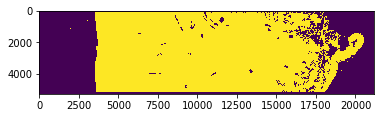

In [38]:
mask = remove_small_holes(mask, 15000)
plt.imshow(mask)

In [39]:
#plt.savefig('./Output/mask.png', dpi = 500)

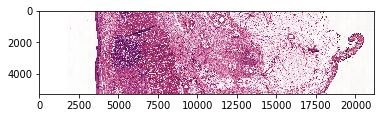

In [40]:
fig = plt.figure()
plt.imshow(img)
#plt.savefig('./Output/img.png', dpi = 500)

## SLIC - a simple segmentation to obtain super pixels.

We next use SLIC to obtain superpixels. The goal is to have the super pixels centers on which we will use our model to predict the class.

In [41]:
# SLIC label
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
start_time = time.time()
segments_slic = slic(img, n_segments=n_segments, compactness=10, sigma=1, enforce_connectivity=True)
regions = regionprops(segments_slic)
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
end_time = time.time()
print('Time:', end_time - start_time)

SLIC number of segments: 22532
Time: 203.61837244033813


SLIC number of segments: 22532


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SLIC-33333')

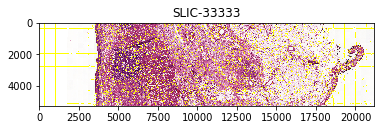

In [42]:
%matplotlib inline
#plt.rcParams["figure.figsize"] = [10, 20]
fig, ax = plt.subplots()
print(f"SLIC number of segments: {len(np.unique(segments_slic))}")
ax.imshow(mark_boundaries(img, segments_slic, mode='thick', color=(50, 50, 0), outline_color=None, background_label=0))
plt.title(f'SLIC-{n_segments}')
#fig.savefig(f'./Output/SLIC-{n_segments}.png', bbox_inches='tight', dpi=1000)

**We then use the helper function CentersSLIC to output the centers of the superpixels and their corresponding indices.**

In [43]:
index, centers = CentersSLIC(regions, mask)

At the end of this step, we obtain a labeled matrix (segments_slic) and the centers of the super pixels. We are ready to make the output for these super pixels.

## Making outputs using the multiresolution model

We first need to import this model from the module in trg_ltran/src/models/

In [44]:
import sys

In [45]:
from src.models.MultiResSmallNetwork import MergeSmallNetworks

Now, we initialize the model and reload it from the file contained in trg_ltran/models/.

In [46]:
#Load model and make outputs
device = torch.device('cuda')
checkpoint = torch.load(modelpath, map_location=lambda storage, loc: storage)
model=MergeSmallNetworks(nclasses = nclasses, outputsize = n_classes).to(device)
model.load_state_dict(checkpoint["model_dict"])

<All keys matched successfully>

Then, we make the output, by using the helper function MakeOutput, and store it in clusterids

In [47]:
clusterids = MakeOutput(model, device, img, centers, patch_size, patch_size_res2, batch_size)

**We assemble the output image from the resulted ids, and the superpixel segmentations.**

In [48]:
regions = regionprops(segments_slic)
result = OutputMasks(mask, regions, centers, index, clusterids)

The, draw it using matplotlib.

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(2, 1, gridspec_kw = {'wspace':0, 'hspace':0})
img0 = img[mirror_pad_size: - mirror_pad_size, mirror_pad_size:-mirror_pad_size, :]
result0 = result[mirror_pad_size: - mirror_pad_size, mirror_pad_size:-mirror_pad_size]

data = result0
cmap = plt.get_cmap('tab10', np.max(result0)-np.min(result0)+1)
ax[0].imshow(img0)
ax[1].imshow(img0)
cax = ax[1].imshow(data, interpolation=None, cmap=cmap, vmin = np.min(result0)-.5, vmax = np.max(result0)+.5, alpha = 0.8)
ax[1].set_title('SLIC + multires-CNN')
divider = make_axes_locatable(ax[1])
caxx = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(cax,cax = caxx, ticks=np.arange(np.min(result0),np.max(result0)+1, 1))
label = ['None'] + class_names
cbar.ax.set_yticklabels(labels)  # horizontal colorbar
plt.show()

In [50]:
#fig.savefig('./Output/output.png', bbox_inches='tight', dpi=700)

## Making object-like masks

From this point on, we have the result stored on the variable 'result'. This image contains interger pixels indicating its type of tissue. The values varies from 0 to 8 corresponding to  the list [ "None", "Fat", "Muscular", "Vessle", "Gland", "Stroma", "Tumor", "Necrosis", "Epithelium"] respectively.

This section is devoted to transforming this result into 'acceptable' mask like objects.


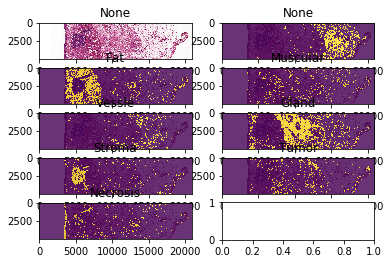

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(5, 2)
img0 = img[mirror_pad_size: - mirror_pad_size, mirror_pad_size:-mirror_pad_size, :]
result0 = result[mirror_pad_size: - mirror_pad_size, mirror_pad_size:-mirror_pad_size]

for i in range(5):
    for j in range(2):
        k = 2*i+j
        if k == 9: 
            break
        if (i, j)==(0, 0):
            data = img0
        else:
            data = (result0 == k)
        #cmap = plt.get_cmap('tab10', np.max(result0)-np.min(result0)+1)
        ax[i, j].imshow(img0)
        cax = ax[i, j].imshow(data, alpha = 0.8)
        ax[i, j].set_title(class_names[k])        
plt.show()
#fig.savefig(f'./Output/masks-SLIC-{n_segments}.png', bbox_inches='tight', dpi=1000)

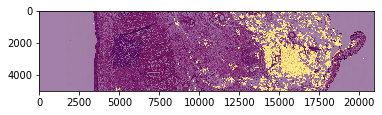

In [52]:
from scipy.ndimage.morphology import binary_fill_holes
image = result0==1
fig, ax = plt.subplots()
ax.imshow(img0)
d = binary_fill_holes(image, structure=np.ones((10,10))).astype(int)
ax.imshow(d, alpha = 0.5)

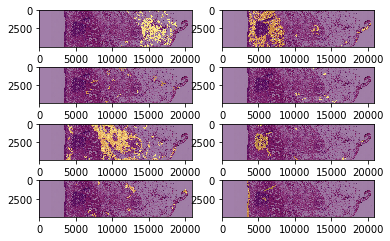

In [53]:
%matplotlib inline
from skimage import morphology
fig, ax = plt.subplots(4, 2)
for i in range(4):
    for j in range(2):
        k = i*2 +j
        image = result0==k+1
        ax[i, j].imshow(img0)
        d = morphology.remove_small_objects(image, 50000)
        ax[i, j].imshow(d, alpha = 0.5)
plt.show()

In [ ]:
%matplotlib inline
from skimage import morphology
fig, ax = plt.subplots(4, 2)
for i in range(4):
    for j in range(2):
        k = i*2 +j
        image = result0==k+1
        ax[i, j].imshow(img0)
        c = morphology.remove_small_holes(image, 20000)
        d = morphology.remove_small_objects(c, 20000)
        b = morphology.convex_hull_object(d)
        ax[i, j].imshow(b, alpha = 0.5)
        

In [ ]:
%matplotlib inline
from skimage import morphology
fig, ax = plt.subplots(4, 2)
for i in range(4):
    for j in range(2):
        k = i*2 +j
        image = result0==k+1
        ax[i, j].imshow(img0)
        c = morphology.remove_small_holes(image, 20000)
        d = morphology.remove_small_objects(c, 20000)
        b = morphology.convex_hull_object(d)
        ax[i, j].imshow(b, alpha = 0.5)

In [ ]:
#fig.savefig(f'./Output/hull-SLIC-{n_segments}.png', bbox_inches='tight', dpi=500)